# Import

In [1]:
import sys
import os
from datetime import datetime

root_dir = '../../../'
if root_dir not in sys.path:
    sys.path.append(root_dir)

import torch
from torch import optim
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_columns', 100)

from modules import losses, models, samplers, searches, evaluators, trainers, datasets, distributions

# Output settings

In [2]:
out_to_file = True
out_dir = '../../out/comparison/ml_20m/'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Dataset

In [3]:
dataset = datasets.ML20m()
n_user = dataset.n_user
n_item = dataset.n_item
n_feedback = dataset.n_pos_pairs
train_set, test_set = dataset.get_train_and_test_set(neg_pair_weight=10)

In [4]:
print(f'n_user = {n_user}')
print(f'n_item = {n_item}')
print(f'n_feedback = {n_feedback}')

n_user = 137330
n_item = 20720
n_feedback = 9993294


# Device

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_set = torch.LongTensor(train_set).to(device)
test_set = torch.FloatTensor(test_set).to(device)

In [6]:
print(device)

cuda:0


# Evaluator

In [7]:
# The size of recommendation set (K)
ks = [10]

score_function_dict = {
    "Recall"       : evaluators.recall,
    "Unpopularity" : evaluators.unpopularity,
    "Serendipity"  : evaluators.serendipity,
    "Long-tail rate": evaluators.longtail_rate,
}
userwise = evaluators.UserwiseEvaluator(test_set, score_function_dict, ks)

# Sampler

In [8]:
sampler = samplers.BaseSampler(train_set, n_user, n_item, device=device, strict_negative=False)

# Model

In [9]:
# Hyperparameters
lr = 1e-3
n_dim = 10
n_batch = 256
n_epoch = 50
no_progressbar = True

model = models.CollaborativeMetricLearning(n_user, n_item, n_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = losses.SumTripletLoss(margin=1).to(device)
trainer = trainers.BaseTrainer(model, optimizer, criterion, sampler, no_progressbar)

# Result (before training)

In [10]:
knn = searches.NearestNeighborhood(model)

In [11]:
trainer.valid(knn, userwise)
re_pre = trainer.valid_scores.copy()

In [12]:
if out_to_file:
    now = datetime.now()
    file_name = now.strftime("pre_%Y_%m_%d_%H%M.csv")
    re_pre.to_csv(out_dir + file_name, index=False)

display(re_pre)

,Recall@10,Unpopularity@10,Serendipity@10,Long-tail rate@10
0,0.126143,5014.596671,2.254523,0.731973


# Training

In [13]:
trainer.fit(n_batch, n_epoch)

# Result

## CML (Base)

In [14]:
knn = searches.NearestNeighborhood(model)

In [15]:
trainer.valid(knn, userwise)
re_base = trainer.valid_scores.copy()

In [16]:
if out_to_file:
    now = datetime.now()
    file_name = now.strftime("base_%Y_%m_%d_%H%M.csv")
    re_base.to_csv(out_dir + file_name, index=False)

display(re_base)

,Recall@10,Unpopularity@10,Serendipity@10,Long-tail rate@10
0,0.487853,916.887402,2.327908,0.134518


# MPCMP

In [17]:
# Hyperparameters
n_sample = 100
bias_li = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
gamma = distributions.Gamma()

In [18]:
rows = []
for bias in bias_li:
    print(f'Prosessing... [bias = {bias}]')
    
    mp = searches.MutualProximity(model, gamma, n_sample, bias)
    
    trainer.valid(mp, userwise)
    row = trainer.valid_scores.copy()
    
    row.insert(0, 'Bias', bias)
    
    rows.append(row)

re_mpcml = pd.concat(rows)

Prosessing... [bias = 0.0]
Prosessing... [bias = 0.1]
Prosessing... [bias = 0.2]
Prosessing... [bias = 0.3]
Prosessing... [bias = 0.4]
Prosessing... [bias = 0.5]
Prosessing... [bias = 0.6]
Prosessing... [bias = 0.7]
Prosessing... [bias = 0.8]
Prosessing... [bias = 0.9]
Prosessing... [bias = 1.0]


In [19]:
if out_to_file:
    now = datetime.now()
    file_name = now.strftime("mpcml_%Y_%m_%d_%H%M.csv")
    re_mpcml.to_csv(out_dir + file_name, index=False)

display(re_mpcml)

,Bias,Recall@10,Unpopularity@10,Serendipity@10,Long-tail rate@10
0,0.0,0.024377,5499.772491,2.328215,0.802760
0,0.1,0.029272,5225.808947,2.350691,0.765082
0,0.2,0.034698,5027.732865,2.355645,0.737646
0,0.3,0.042109,4843.270711,2.366926,0.711641
0,0.4,0.052428,4649.623043,2.409644,0.683671
0,0.5,0.068281,4415.584400,2.444999,0.650051
0,0.6,0.094612,4112.761416,2.489207,0.605943
0,0.7,0.138488,3687.409055,2.540074,0.543602
0,0.8,0.211161,3060.540812,2.557087,0.451362
0,0.9,0.326572,2134.132885,2.526121,0.314816


## CML vs MPCML

In [20]:
# df -> list

k = 10
n_bias = len(bias_li)

# Before training
recall_pre         = re_pre[f'Recall@{k}'].tolist() * n_bias
unpopularity_pre   = re_pre[f'Unpopularity@{k}'].tolist() * n_bias
serndipity_pre     = re_pre[f'Serendipity@{k}'].tolist() * n_bias
longtale_pre       = re_pre[f'Long-tail rate@{k}'].tolist() * n_bias

# CML(Base)
recall_base        = re_base[f'Recall@{k}'].tolist() * n_bias
unpopularity_base  = re_base[f'Unpopularity@{k}'].tolist() * n_bias
serndipity_base    = re_base[f'Serendipity@{k}'].tolist() * n_bias
longtale_base      = re_base[f'Long-tail rate@{k}'].tolist() * n_bias

# MPCML
recall_mpcml       = re_mpcml[f'Recall@{k}'].tolist()
unpopularity_mpcml = re_mpcml[f'Unpopularity@{k}'].tolist()
serndipity_mpcml   = re_mpcml[f'Serendipity@{k}'].tolist()
longtale_mpcml     = re_mpcml[f'Long-tail rate@{k}'].tolist()

### Recall vs Unpopularity

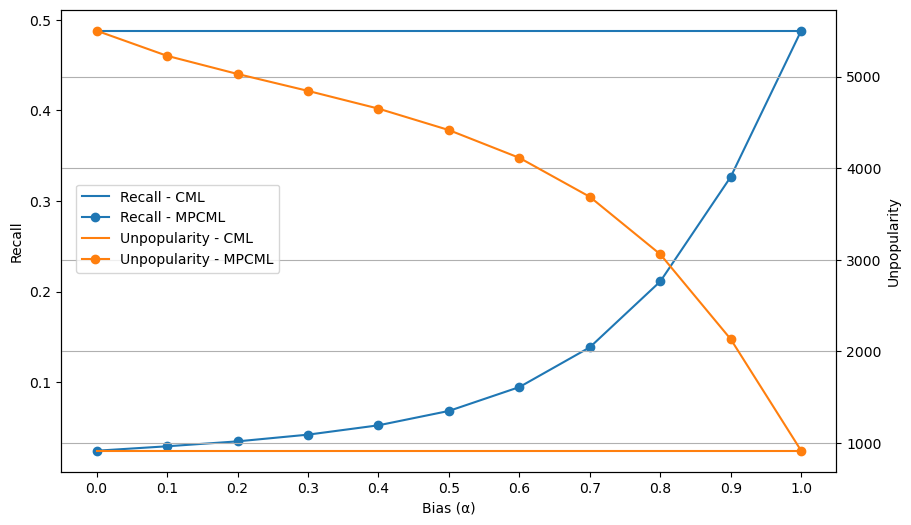

In [21]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Recall
line_recall_base  = ax1.plot(bias_li, recall_base,  label='Recall - CML', color='tab:blue')
line_recall_mpcml = ax1.plot(bias_li, recall_mpcml, label='Recall - MPCML', marker='o', color='tab:blue')

# Unpopularity
ax2 = ax1.twinx()
line_unpop_base  = ax2.plot(bias_li, unpopularity_base,  label='Unpopularity - CML', color='tab:orange')
line_unpop_mpcml = ax2.plot(bias_li, unpopularity_mpcml, label='Unpopularity - MPCML', marker='o', color='tab:orange')

ax1.set_xticks(bias_li)
ax1.tick_params(axis='y')
ax2.tick_params(axis='y')
ax1.set_xlabel('Bias (α)')
ax1.set_ylabel('Recall')
ax2.set_ylabel('Unpopularity')

lines = [line_recall_base[0], line_recall_mpcml[0], line_unpop_base[0], line_unpop_mpcml[0]]
labels = [line.get_label() for line in lines]
fig.legend(lines, labels, bbox_to_anchor=(0.35, 0.6))

plt.grid(axis='y')

if out_to_file:
    now = datetime.now()
    file_name = now.strftime("tradeoff_%Y_%m_%d_%H%M.png")
    plt.savefig(out_dir + file_name, bbox_inches='tight')

plt.show()

### Serendipity

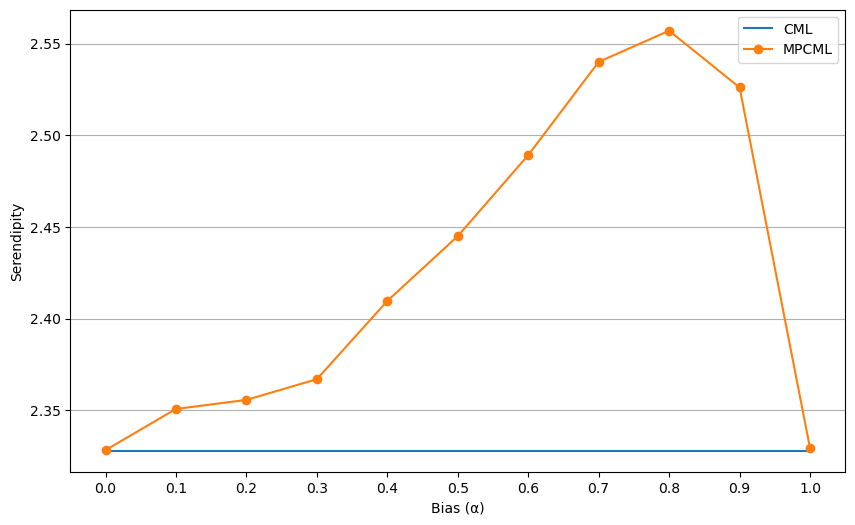

In [22]:
plt.figure(figsize=(10, 6))
# plt.plot(bias_li, serndipity_pre, label='Before training)
plt.plot(bias_li, serndipity_base, label='CML')
plt.plot(bias_li, serndipity_mpcml, label='MPCML', marker='o')

plt.xticks(bias_li)
plt.xlabel('Bias (α)')
plt.ylabel('Serendipity')
plt.legend()
plt.grid(axis='y')

if out_to_file:
    now = datetime.now()
    file_name = now.strftime("serendipity_%Y_%m_%d_%H%M.png")
    plt.savefig(out_dir + file_name, bbox_inches='tight')

plt.show()

### Long-tail rate

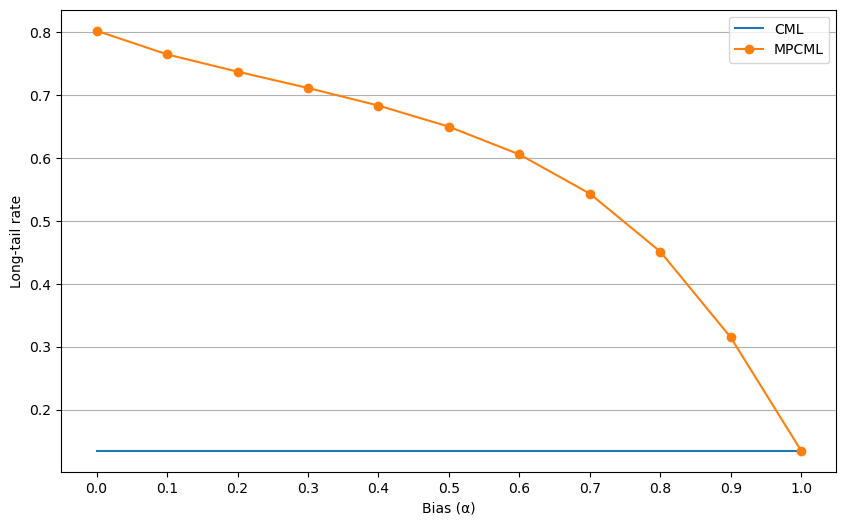

In [23]:
plt.figure(figsize=(10, 6))
# plt.plot(bias_li, longtale_pre, label='Before training')
plt.plot(bias_li, longtale_base, label='CML')
plt.plot(bias_li, longtale_mpcml, label='MPCML', marker='o')

plt.xticks(bias_li)
plt.xlabel('Bias (α)')
plt.ylabel('Long-tail rate')
plt.legend()
plt.grid(axis='y')

if out_to_file:
    now = datetime.now()
    file_name = now.strftime("longtail_%Y_%m_%d_%H%M.png")
    plt.savefig(out_dir + file_name, bbox_inches='tight')

plt.show()